In [1]:
# https://medium.com/thedeephub/building-mae-vision-transformer-from-scratch-using-pytorch-masked-autoencoders-are-scalable-2c2e78e0be02
# https://github.com/ANLGBOY/MADE-with-PyTorch/tree/master
# https://github.com/IcarusWizard/MAE/releases/tag/cifar10

In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.distributions import Bernoulli

import argparse
import os
import random
import numpy as np

BATCH_SIZE=128
EPOCHS=70
LR=1e-3
WEIGHT_DECAT=1e-4
STEP_SIZE=45
GAMMA=0.1
Z1_DIM=500
Z2_DIM=350
LOG_INTERVAL=50
MAKE_IMAGE_INTERVAL=5
INPUT_DIM = 794
OUTPUT_DIM = 784

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# --- data loading --- #
train_data = datasets.MNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST('./data', train=False,
                           transform=transforms.ToTensor())

In [3]:
# pin memory provides improved transfer speed
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=BATCH_SIZE, shuffle=True, **kwargs)


# --- defines the masking matrix --- #
MW0 = np.zeros((Z1_DIM, INPUT_DIM))
MW1 = np.zeros((Z2_DIM, Z1_DIM))
MW2 = np.zeros((Z1_DIM, Z2_DIM))
MV = np.zeros((OUTPUT_DIM, Z1_DIM))
MA = np.zeros((OUTPUT_DIM, INPUT_DIM))

In [4]:



# --- defines the model and the optimizer --- #
class MADE(nn.Module):
    def __init__(self):
        super().__init__()
        # companion layers are for Connectivity-agnostic training
        # direct layer is for direct connection between input and output
        self.fc1 = nn.Linear(INPUT_DIM, Z1_DIM)
        self.fc1_companion = nn.Linear(INPUT_DIM, Z1_DIM)
        self.fc2 = nn.Linear(Z1_DIM, Z2_DIM)
        self.fc2_companion = nn.Linear(Z1_DIM, Z2_DIM)
        self.fc3 = nn.Linear(Z2_DIM, Z1_DIM)
        self.fc3_conpanion = nn.Linear(Z2_DIM, Z1_DIM)
        self.fc4 = nn.Linear(Z1_DIM, OUTPUT_DIM)
        self.fc4_companion = nn.Linear(Z1_DIM, OUTPUT_DIM)
        self.fc_direct = nn.Linear(INPUT_DIM, OUTPUT_DIM)

    def encode(self, x, MW0, MW1):
        masked_fc1 = self.fc1.weight * MW0
        masked_fc2 = self.fc2.weight * MW1
        masked_fc1_companion = self.fc1_companion.weight * MW0
        masked_fc2_companion = self.fc2_companion.weight * MW1
        h1 = F.relu(F.linear(x, masked_fc1, self.fc1.bias) +
                    F.linear(torch.ones_like(x), masked_fc1_companion, self.fc1_companion.bias))
        h2 = F.relu(F.linear(h1, masked_fc2, self.fc2.bias) +
                    F.linear(torch.ones_like(h1), masked_fc2_companion, self.fc2_companion.bias))
        return h2

    def decode(self, x, h2, MW2, MV, MA):
        masked_fc3 = self.fc3.weight * MW2
        masked_fc4 = self.fc4.weight * MV
        masked_fc3_companion = self.fc3_conpanion.weight * MW2
        masked_fc4_companion = self.fc4_companion.weight * MV
        masked_fc_direct = self.fc_direct.weight * MA
        h3 = F.relu(F.linear(h2, masked_fc3, self.fc3.bias) +
                    F.linear(torch.ones_like(h2), masked_fc3_companion, self.fc3_conpanion.bias))
        recon_x = F.linear(h3, masked_fc4, self.fc4.bias) +\
                    F.linear(torch.ones_like(h3), masked_fc4_companion, self.fc4_companion.bias) +\
                    F.linear(x, masked_fc_direct, self.fc_direct.bias)
        return torch.sigmoid(recon_x)

    def forward(self, x, MW0, MW1, MW2, MV, MA):
        h2 = self.encode(x, MW0, MW1)
        recon_x = self.decode(x, h2, MW2, MV, MA)
        return recon_x

In [5]:
model = MADE().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR,weight_decay=WEIGHT_DECAT)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

# --- defines the loss function --- #
def loss_function(recon_x, x):
    BCE = F.binary_cross_entropy(
        recon_x, x.view(-1, OUTPUT_DIM), reduction='sum')
    return BCE

In [12]:



# --- train and test --- #
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        # data: [batch size, 1, 28, 28] -> [batch size, 784]
        data = data.view(-1, 784).to(device)
        batch_size = data.size(0)
        # labels: [batch size, 10] -> 1-hot encoding for a label of the image
        labels = torch.zeros(batch_size, 10).to(device)
        for i in range(len(label)):
            labels[i][label[i]] = 1
        # We use as input the image augmented with label
        data_with_label = torch.cat((labels, data), dim=1)
        optimizer.zero_grad()
        recon_data = model(data_with_label, MW0, MW1, MW2, MV, MA)
        loss = loss_function(recon_data, data)
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx / len(train_loader),
                cur_loss/len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)
    ))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data = data.view(-1, 784).to(device)
            batch_size = data.size(0)
            labels = torch.zeros(batch_size, 10).to(device)
            for i in range(len(label)):
                labels[i][label[i]] = 1
            data_with_label = torch.cat((labels, data), dim=1)
            recon_data = model(data_with_label, MW0, MW1, MW2, MV, MA)
            cur_loss = loss_function(recon_data, data).item()
            test_loss += cur_loss
            if batch_idx == 0 and epoch % MAKE_IMAGE_INTERVAL == 0:
                # saves 8 samples of the first batch as an image file to compare input images and reconstructed images
                num_samples = min(BATCH_SIZE, 8)
                comparison = torch.cat(
                    [data.view(BATCH_SIZE, 1, 28, 28)[:num_samples], recon_data.view(BATCH_SIZE, 1, 28, 28)[:num_samples]]).cpu()
                save_generated_img(
                    comparison, 'reconstruction', epoch, num_samples)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


# --- etc. funtions --- #
def save_generated_img(image, name, epoch, nrow=8):
    if not os.path.exists('results'):
        os.makedirs('results')
    save_path = 'results/'+name+'_'+str(epoch)+'.png'
    save_image(image, save_path, nrow=nrow)


def sample_M():
    global MW0
    global MW1
    global MW2
    global MV
    global MA
    # The first 10 elements of the input are 1-hot encodded label.
    # We assign the value '1' to these elements and assign the value from 1 to 784 to the elements for image
    m0 = list(np.ones(10, dtype=int)) + list(range(1, 785))
    m1 = random.choices(range(1, 784), k=Z1_DIM)
    m2 = random.choices(range(min(m1), 784), k=Z2_DIM)
    m3 = random.choices(range(min(m2), 784), k=Z1_DIM)

    for i in range(Z1_DIM):
        for j in range(INPUT_DIM):
            MW0[i][j] = 1 if m1[i] >= m0[j] else 0

    for i in range(Z2_DIM):
        for j in range(Z1_DIM):
            MW1[i][j] = 1 if m2[i] >= m1[j] else 0

    for i in range(Z1_DIM):
        for j in range(Z2_DIM):
            MW2[i][j] = 1 if m3[i] >= m2[j] else 0

    for i in range(OUTPUT_DIM):
        for j in range(Z2_DIM):
            MV[i][j] = 1 if m0[i] > m3[j] else 0

    for i in range(OUTPUT_DIM):
        for j in range(INPUT_DIM):
            MA[i][j] = 1 if m0[i] > m0[j] else 0

    MW0 = torch.from_numpy(MW0).float().to(device)
    MW1 = torch.from_numpy(MW1).float().to(device)
    MW2 = torch.from_numpy(MW2).float().to(device)
    MV = torch.from_numpy(MV).float().to(device)
    MA = torch.from_numpy(MA).float().to(device)


def sample_image_from_model(epoch):
    model.eval()
    num_sample = 80

    sample_input = torch.rand(num_sample, 784).to(device)
    labels = torch.zeros(num_sample, 10).to(device)

    for i in range(num_sample):
        labels[i][i%10] = 1

    sample_input = torch.cat((labels, sample_input), dim=1)
    with torch.no_grad():
        for i in range(10, 794):
                output = model(sample_input, MW0, MW1, MW2, MV, MA)
                dist = Bernoulli(output[:,i-10])
                sample_output = dist.sample()
                sample_input[:, i] = sample_output
    sample = sample_input[:, 10:].cpu().view(num_sample, 1, 28, 28)
    save_generated_img(sample, 'sample', epoch, 10)
    return(sample)

In [7]:
EPOCHS=10

In [8]:

sample_M()
for epoch in range(1, EPOCHS + 1):
    scheduler.step(epoch)
    train(epoch)
    test(epoch)
    if epoch % MAKE_IMAGE_INTERVAL == 0:
        sample_image_from_model(epoch)

/gpfs/scratch/nk4167/miniconda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/gpfs/scratch/nk4167/miniconda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues

Train Epoch: 1 [0/60000 (0%)]	Loss: 556.429810
Train Epoch: 1 [6400/60000 (11%)]	Loss: 211.323013
Train Epoch: 1 [12800/60000 (21%)]	Loss: 185.238342
Train Epoch: 1 [19200/60000 (32%)]	Loss: 171.218689
Train Epoch: 1 [25600/60000 (43%)]	Loss: 167.689377
Train Epoch: 1 [32000/60000 (53%)]	Loss: 158.848755
Train Epoch: 1 [38400/60000 (64%)]	Loss: 150.993896
Train Epoch: 1 [44800/60000 (75%)]	Loss: 145.599655
Train Epoch: 1 [51200/60000 (85%)]	Loss: 145.457916
Train Epoch: 1 [57600/60000 (96%)]	Loss: 136.765533
====> Epoch: 1 Average loss: 169.8154
====> Test set loss: 135.8407
Train Epoch: 2 [0/60000 (0%)]	Loss: 139.229858
Train Epoch: 2 [6400/60000 (11%)]	Loss: 137.121429
Train Epoch: 2 [12800/60000 (21%)]	Loss: 131.859879
Train Epoch: 2 [19200/60000 (32%)]	Loss: 131.341904
Train Epoch: 2 [25600/60000 (43%)]	Loss: 126.233643
Train Epoch: 2 [32000/60000 (53%)]	Loss: 129.338562
Train Epoch: 2 [38400/60000 (64%)]	Loss: 125.214394
Train Epoch: 2 [44800/60000 (75%)]	Loss: 122.272743
Train Ep

In [13]:
res = sample_image_from_model(epoch)

In [16]:
import matplotlib.pyplot as plt

In [19]:
%matplotlib inline

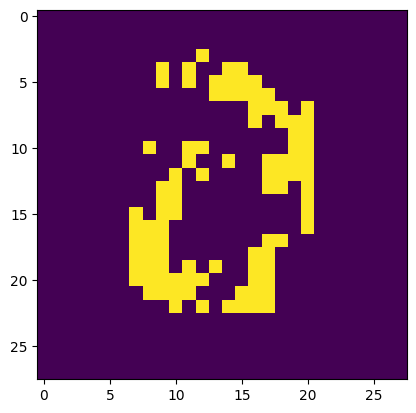

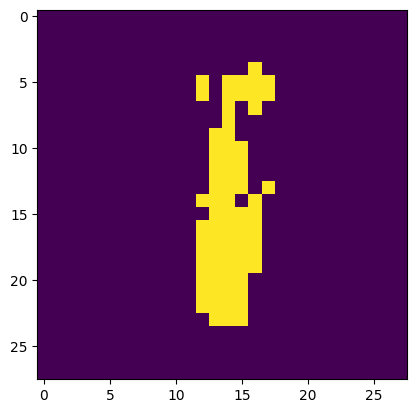

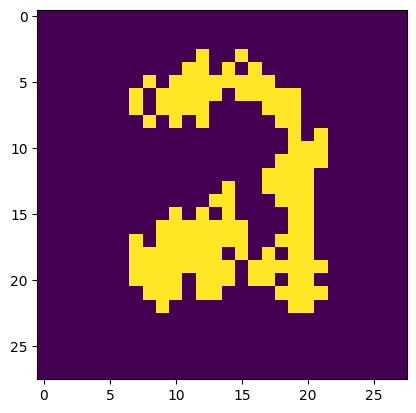

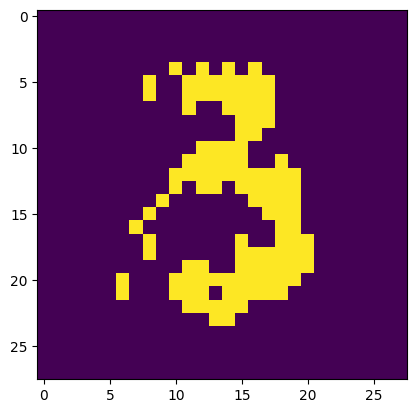

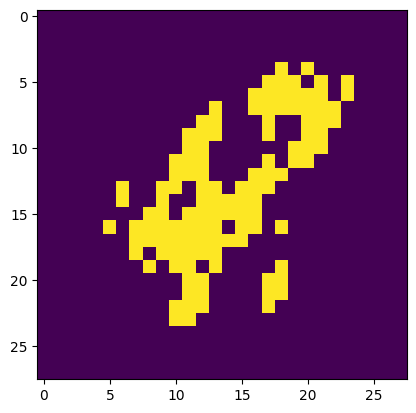

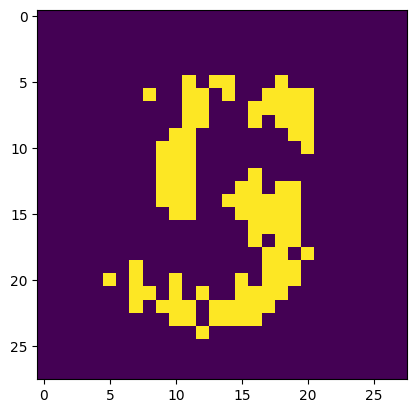

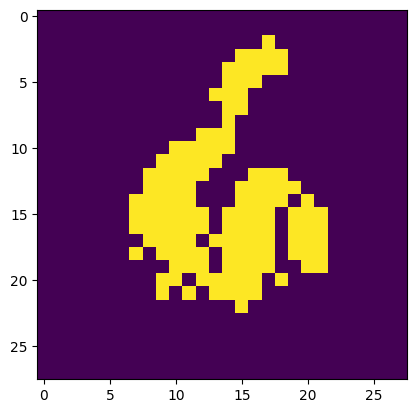

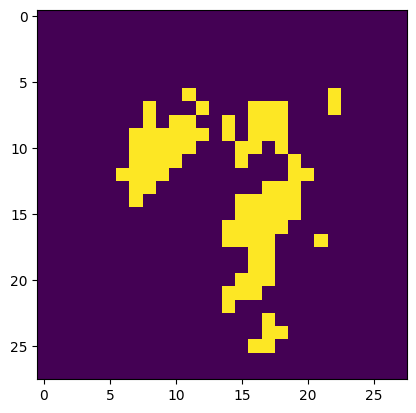

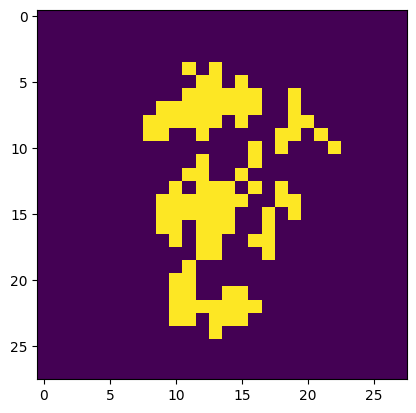

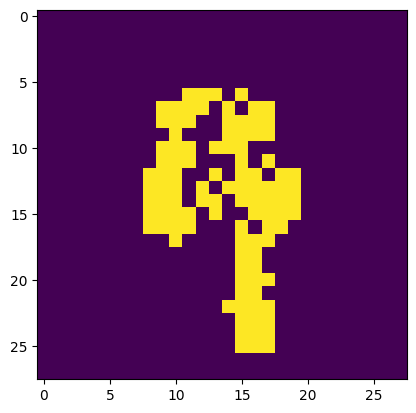

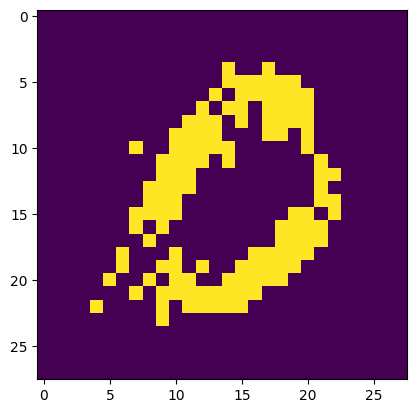

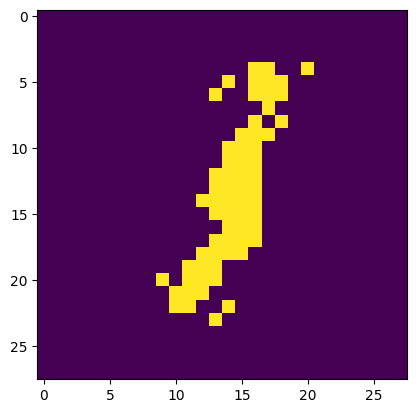

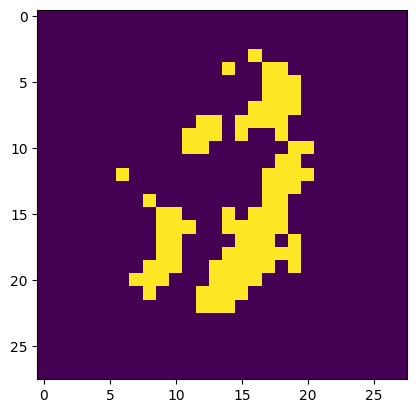

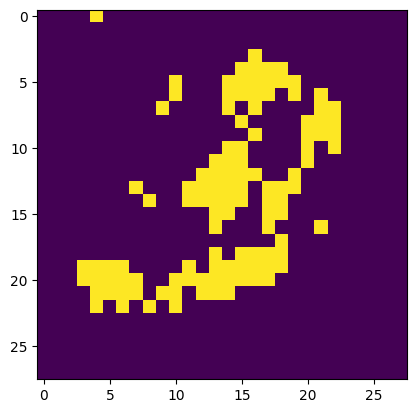

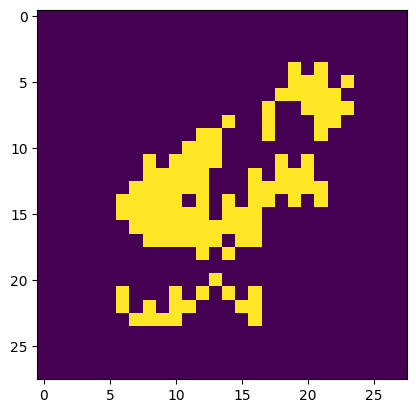

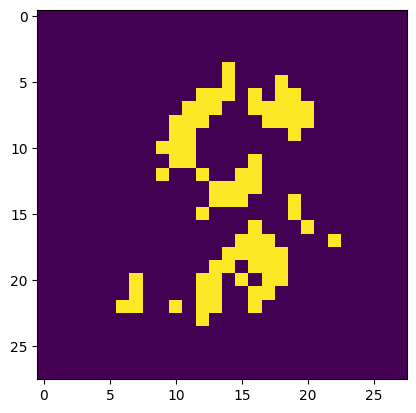

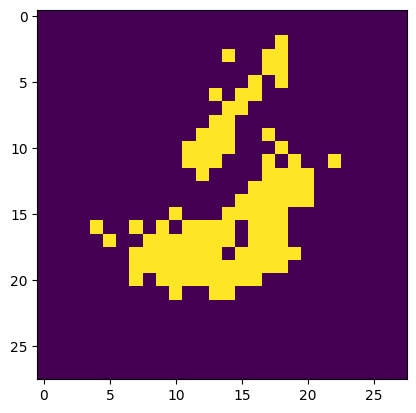

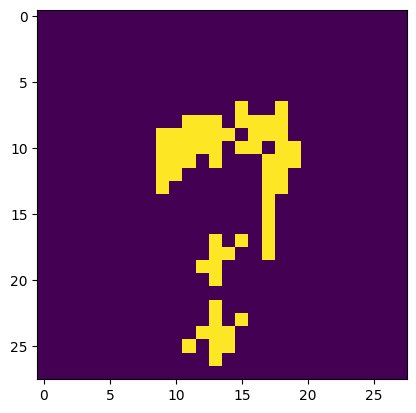

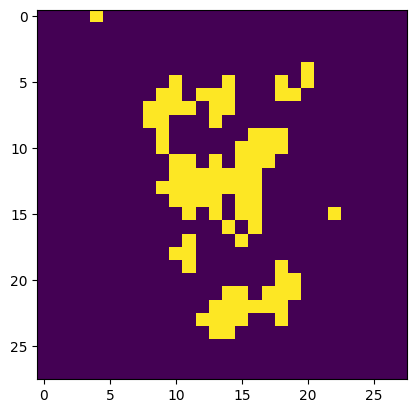

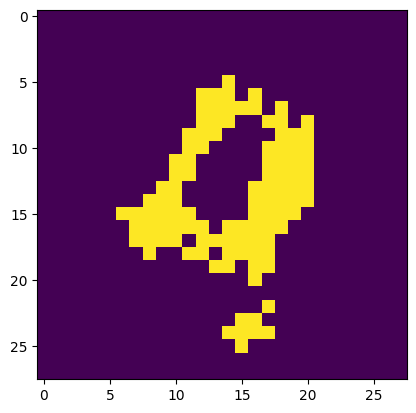

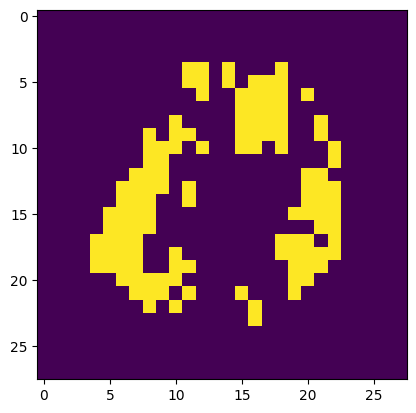

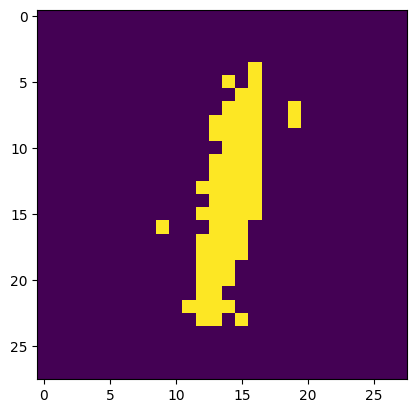

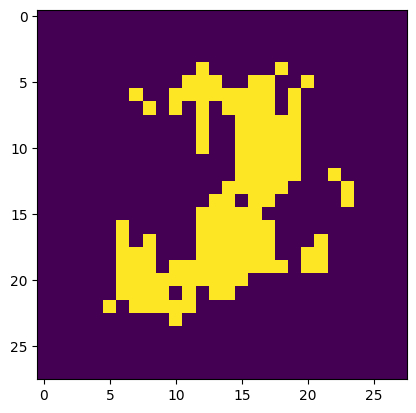

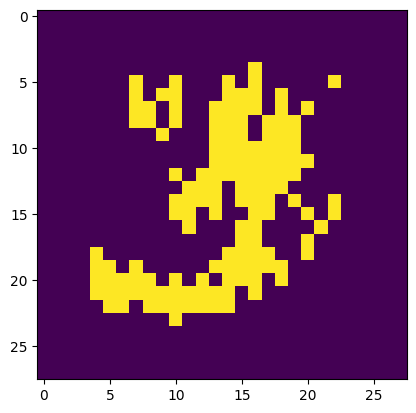

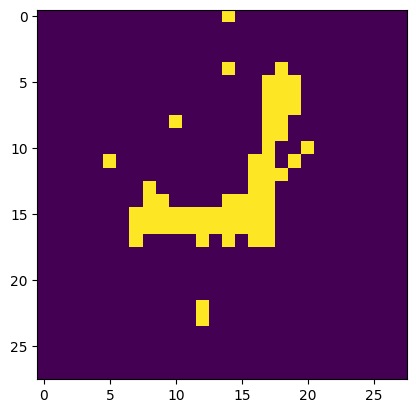

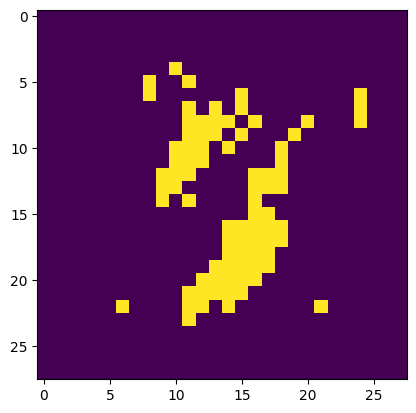

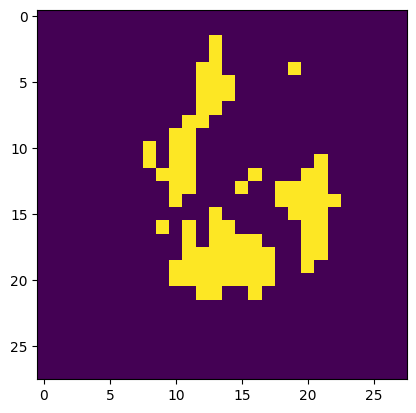

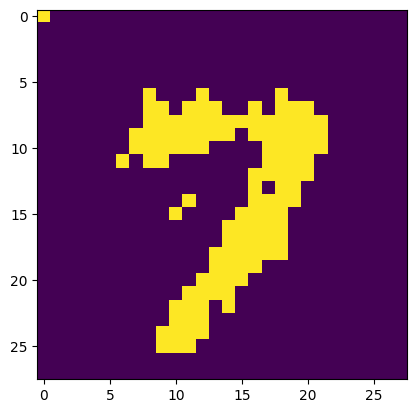

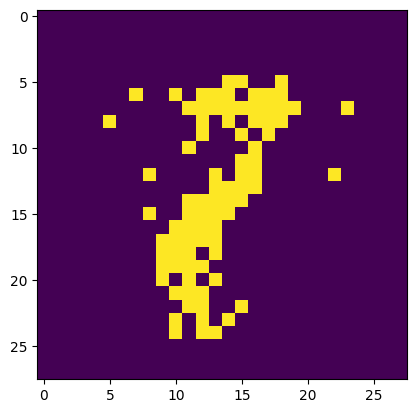

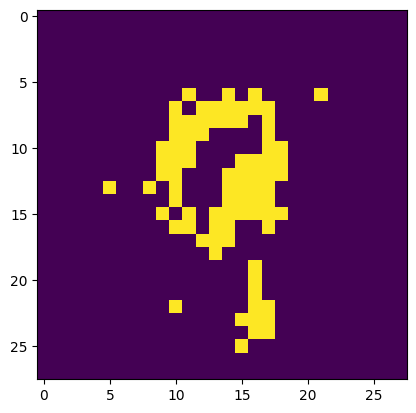

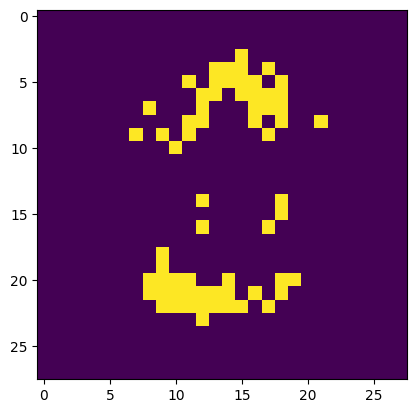

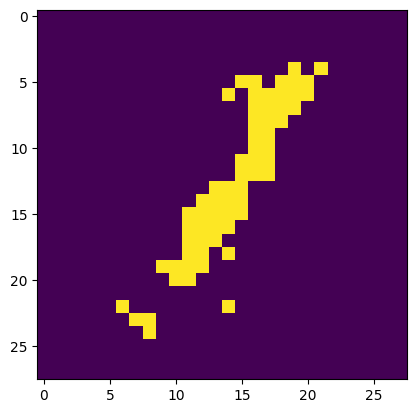

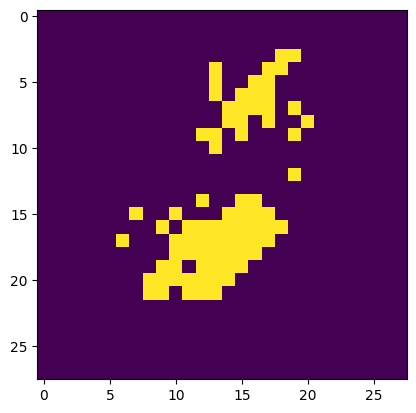

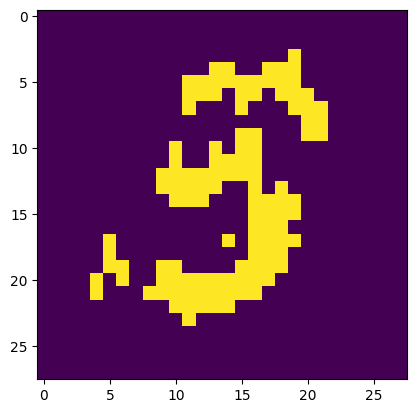

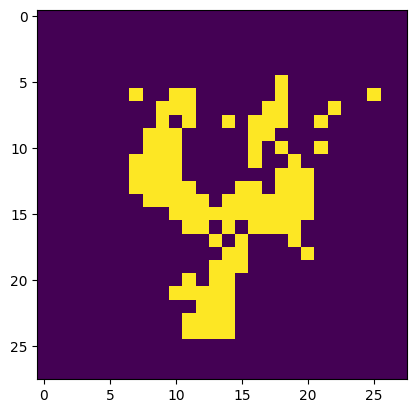

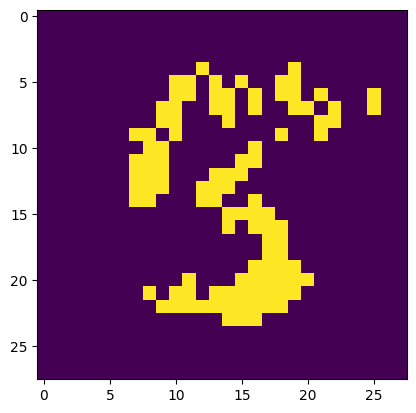

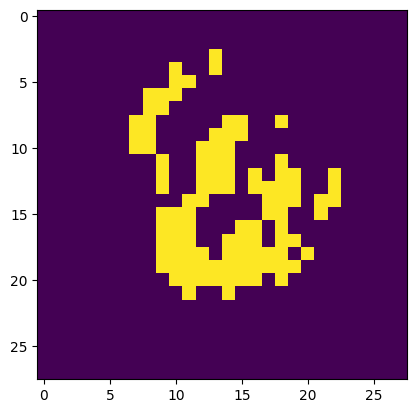

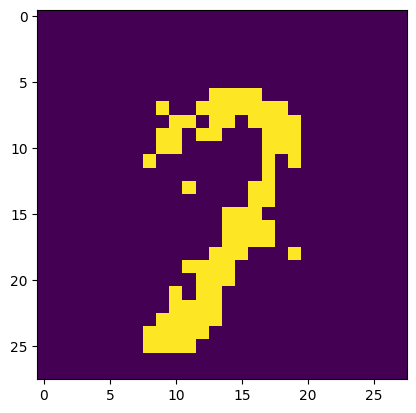

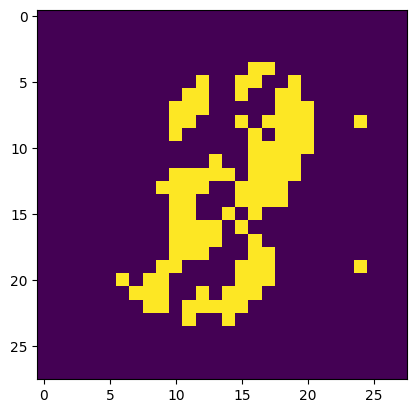

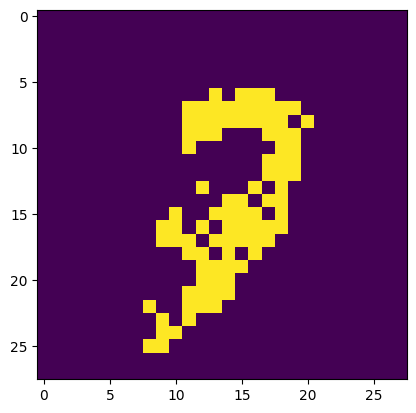

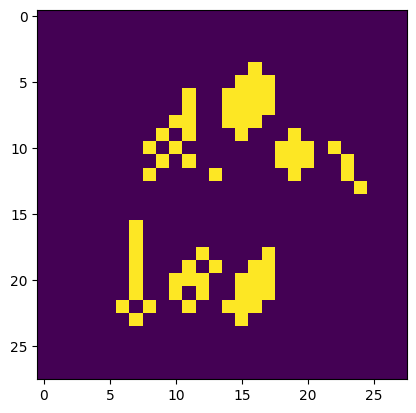

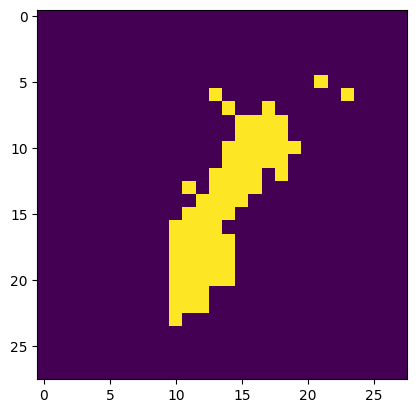

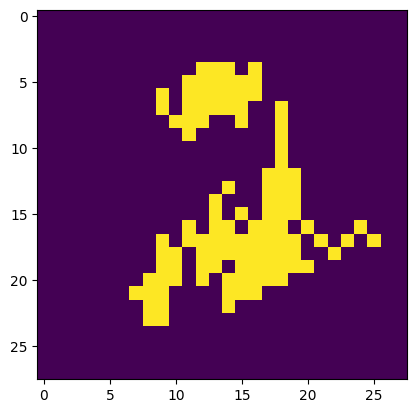

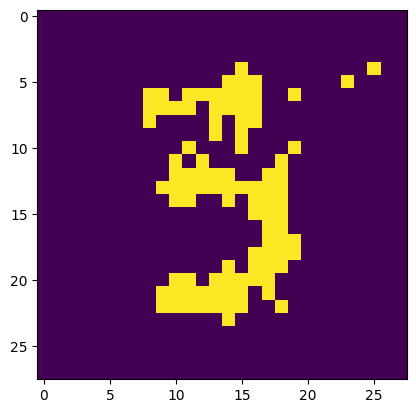

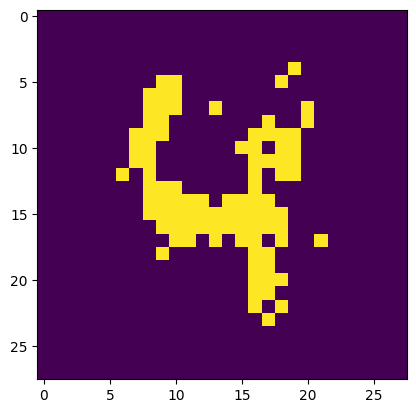

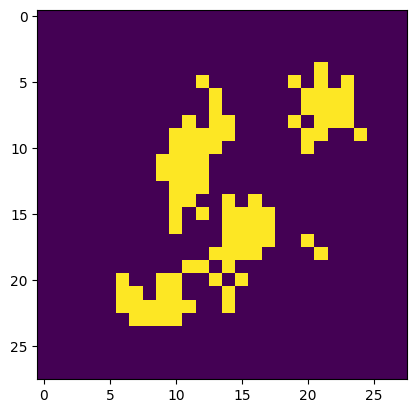

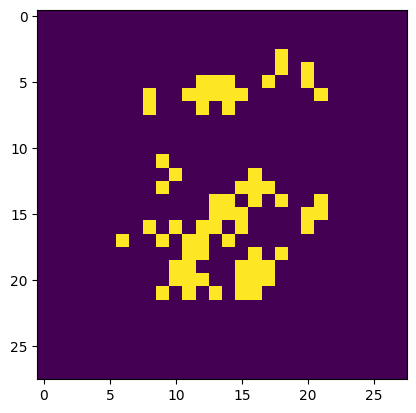

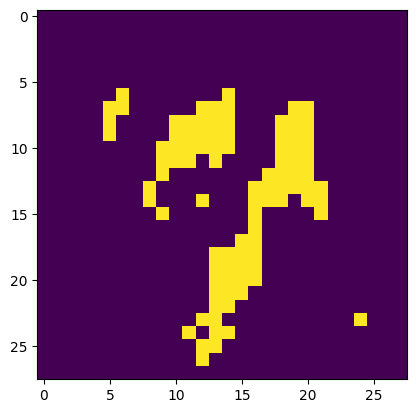

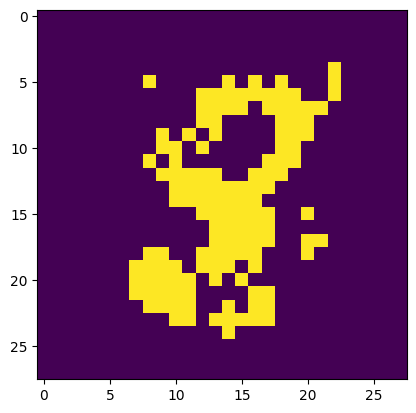

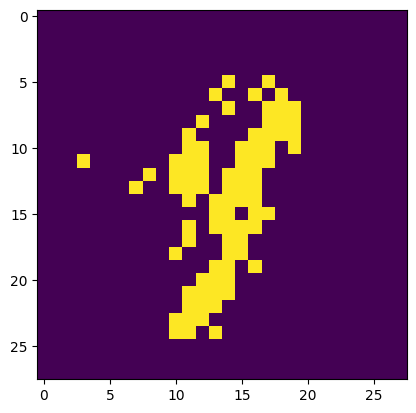

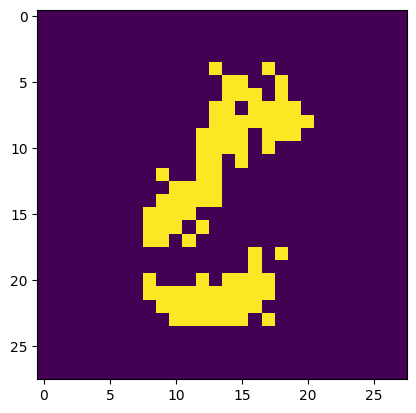

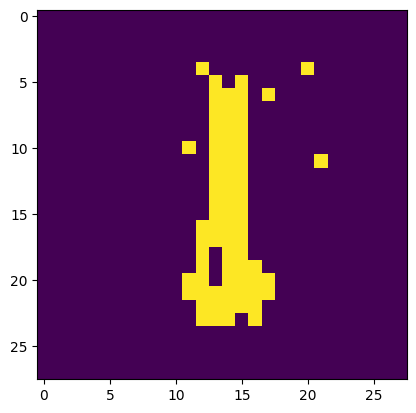

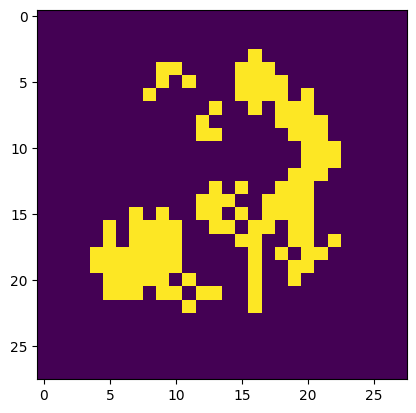

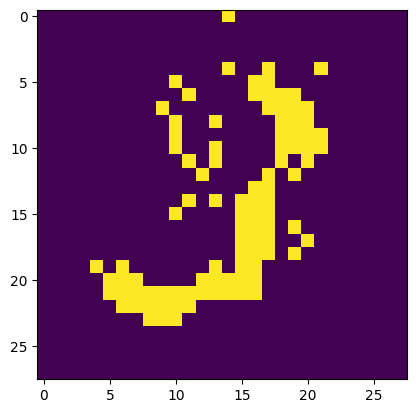

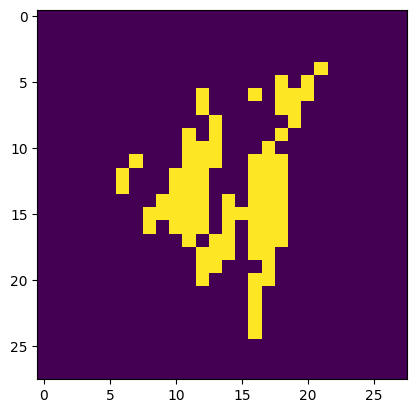

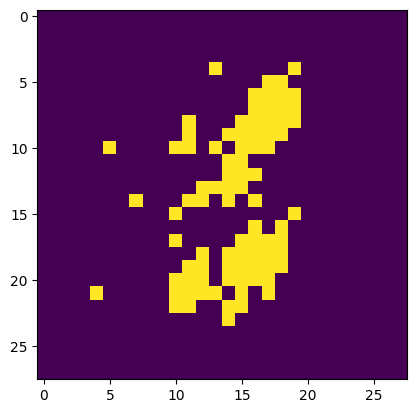

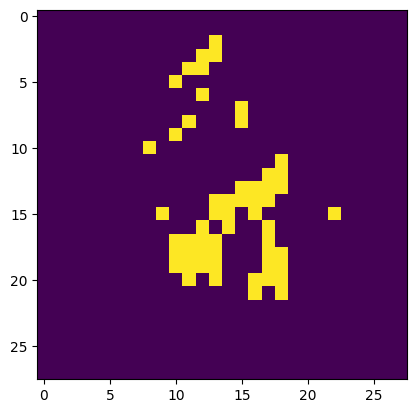

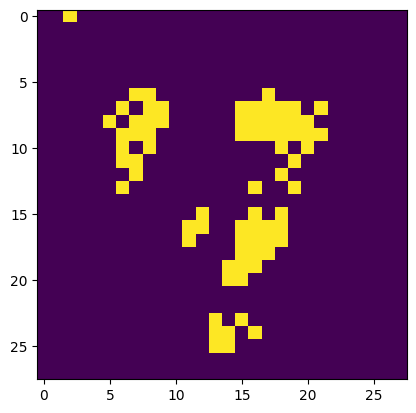

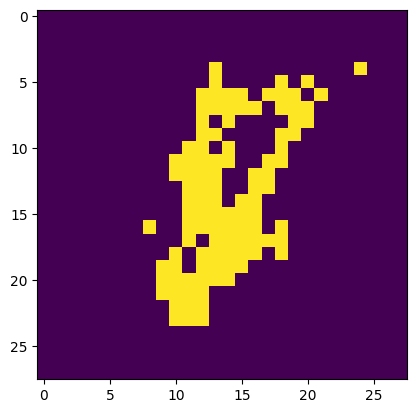

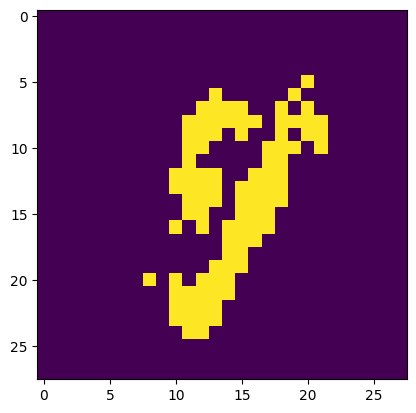

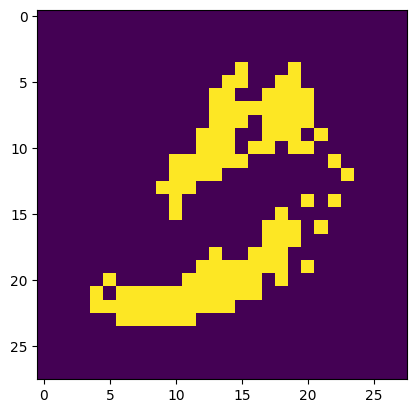

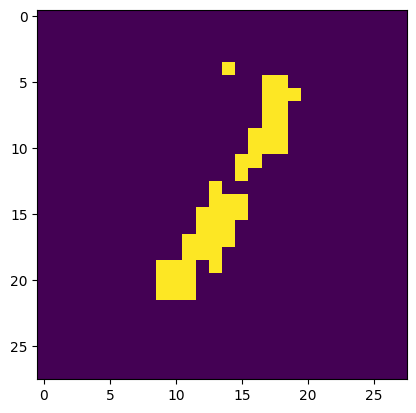

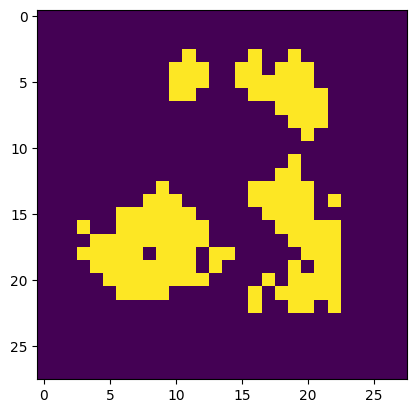

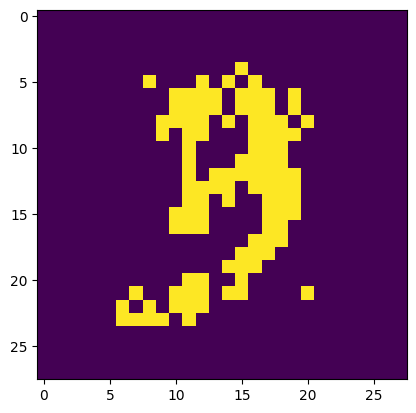

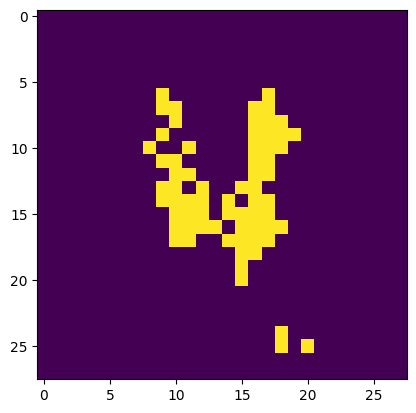

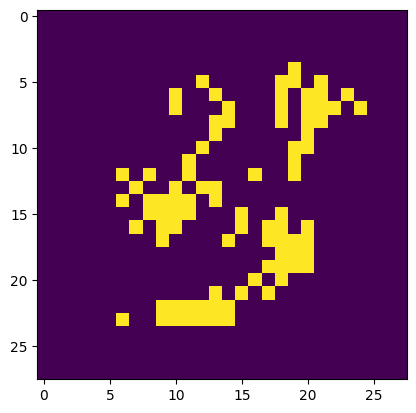

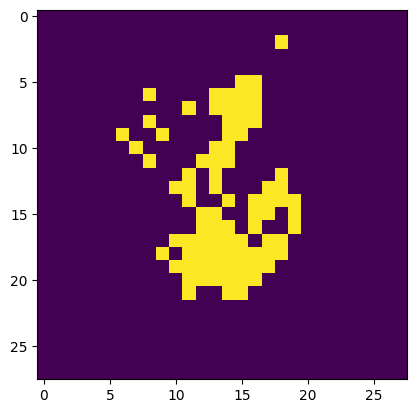

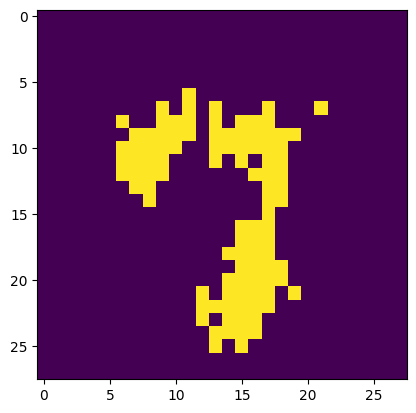

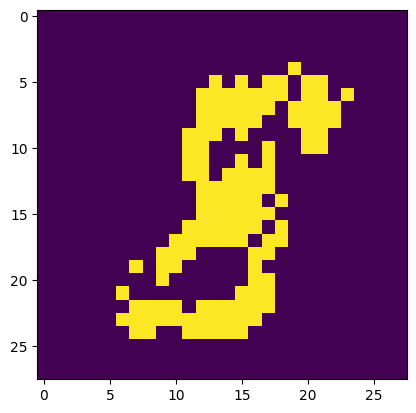

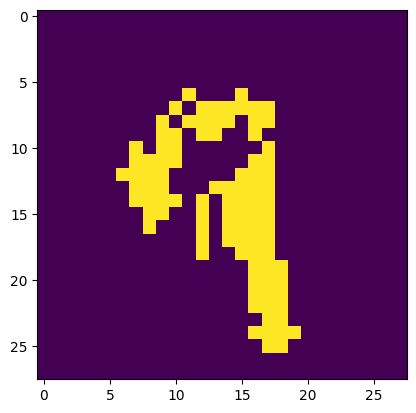

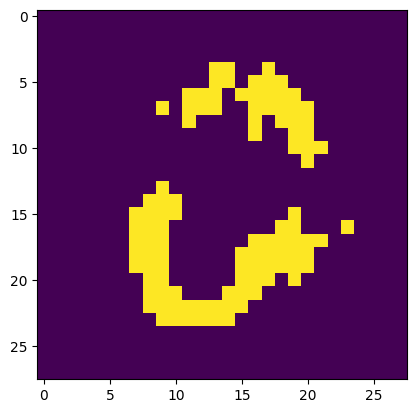

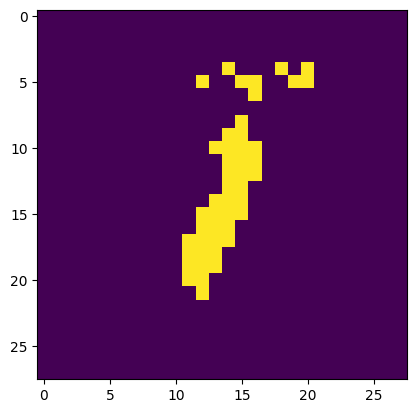

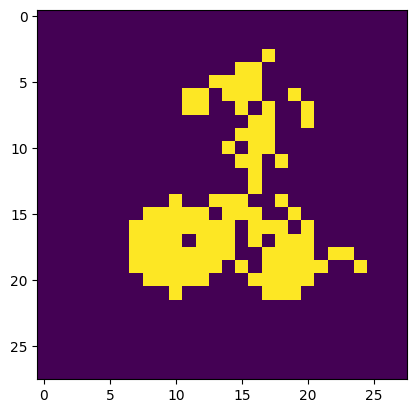

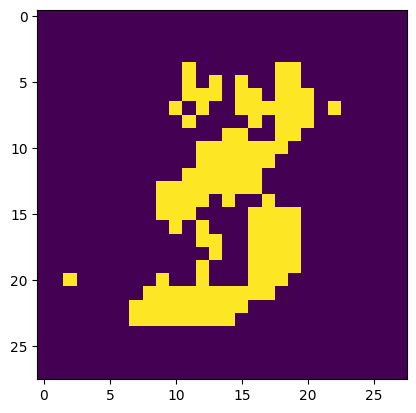

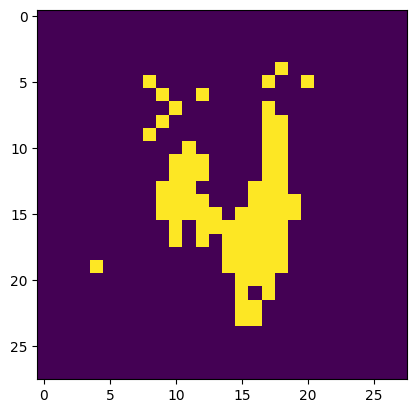

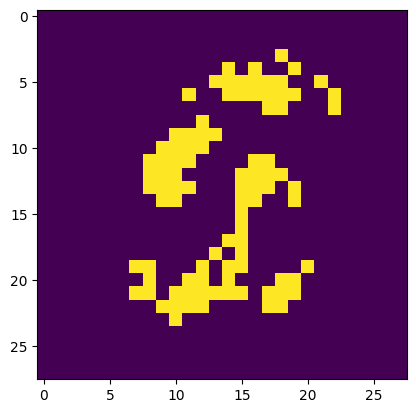

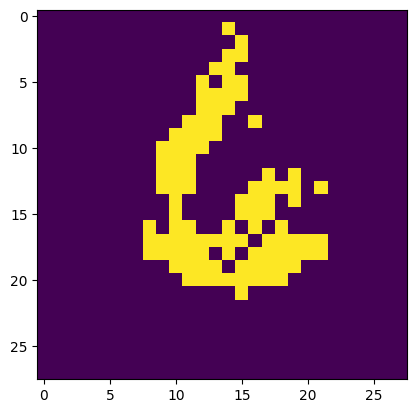

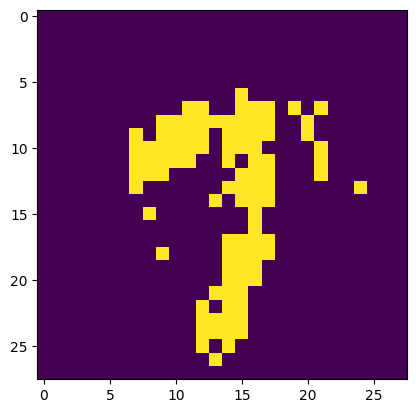

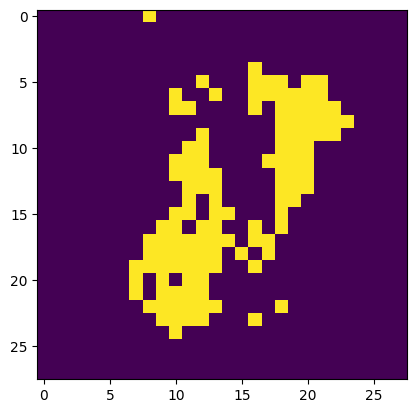

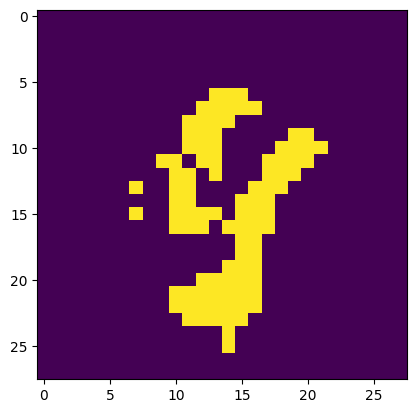

In [22]:
for i in range(res.shape[0]):
    img = res[i,0,:,:]
    plt.imshow(img)
    plt.show()

In [23]:
EPOCHS=20

In [24]:
for epoch in range(1, EPOCHS + 1):
    scheduler.step(epoch)
    train(epoch)
    test(epoch)
    if epoch % MAKE_IMAGE_INTERVAL == 0:
        sample_image_from_model(epoch)

/gpfs/scratch/nk4167/miniconda/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Epoch: 1 [0/60000 (0%)]	Loss: 93.896774
Train Epoch: 1 [6400/60000 (11%)]	Loss: 95.886169
Train Epoch: 1 [12800/60000 (21%)]	Loss: 93.900970
Train Epoch: 1 [19200/60000 (32%)]	Loss: 92.967316
Train Epoch: 1 [25600/60000 (43%)]	Loss: 95.701889
Train Epoch: 1 [32000/60000 (53%)]	Loss: 92.192726
Train Epoch: 1 [38400/60000 (64%)]	Loss: 95.167618
Train Epoch: 1 [44800/60000 (75%)]	Loss: 95.813179
Train Epoch: 1 [51200/60000 (85%)]	Loss: 93.209900
Train Epoch: 1 [57600/60000 (96%)]	Loss: 94.699738
====> Epoch: 1 Average loss: 93.8368
====> Test set loss: 92.5776
Train Epoch: 2 [0/60000 (0%)]	Loss: 93.687241
Train Epoch: 2 [6400/60000 (11%)]	Loss: 92.086411
Train Epoch: 2 [12800/60000 (21%)]	Loss: 92.655380
Train Epoch: 2 [19200/60000 (32%)]	Loss: 91.658249
Train Epoch: 2 [25600/60000 (43%)]	Loss: 95.687706
Train Epoch: 2 [32000/60000 (53%)]	Loss: 91.213150
Train Epoch: 2 [38400/60000 (64%)]	Loss: 90.699554
Train Epoch: 2 [44800/60000 (75%)]	Loss: 93.334427
Train Epoch: 2 [51200/60000 

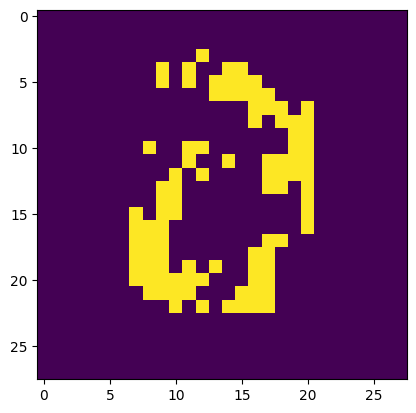

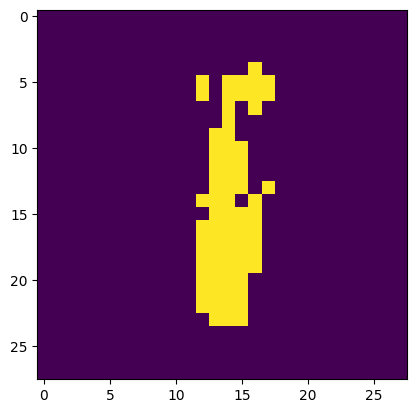

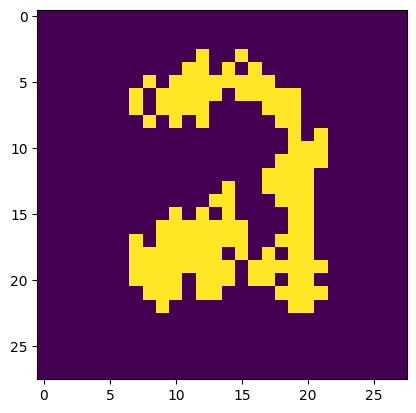

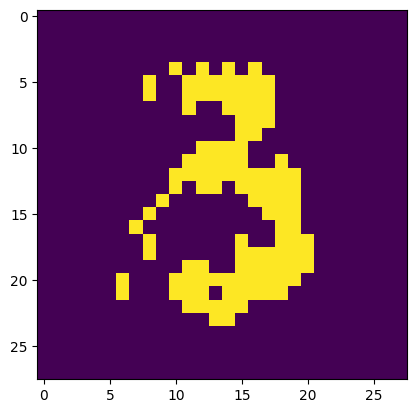

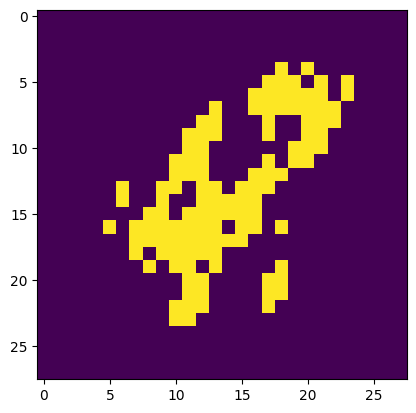

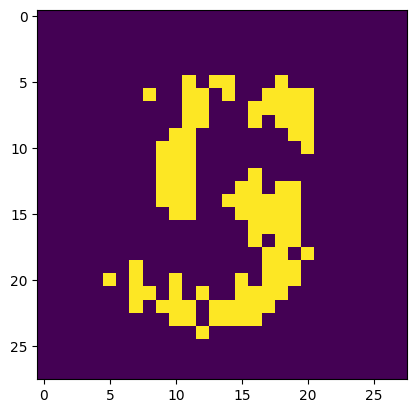

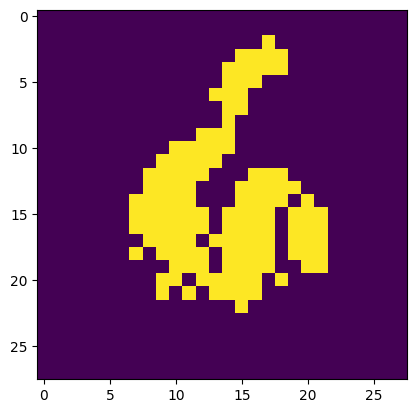

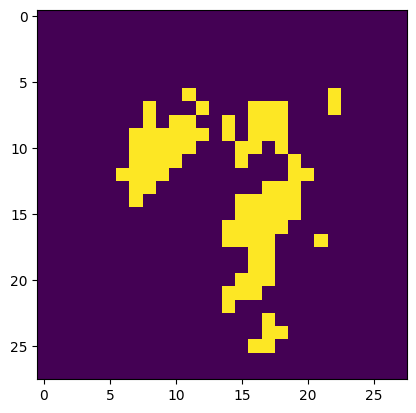

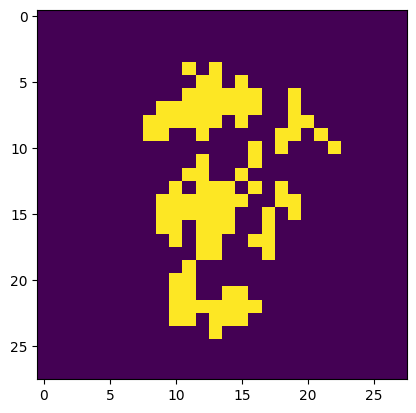

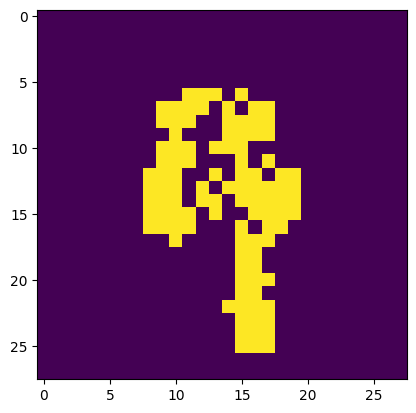

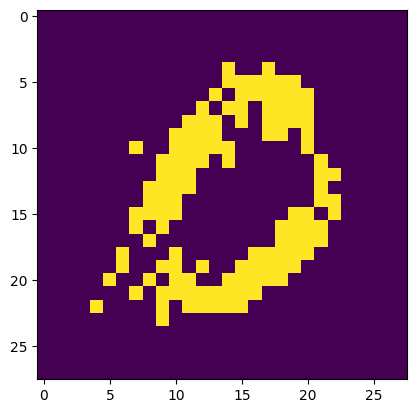

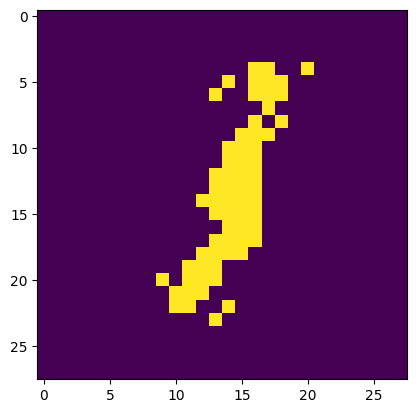

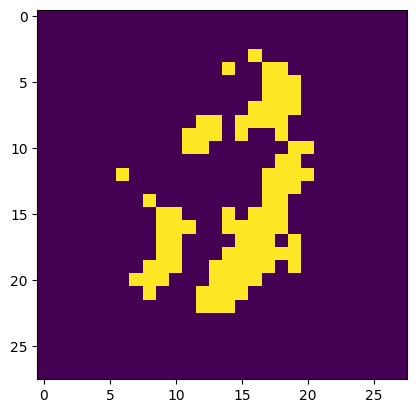

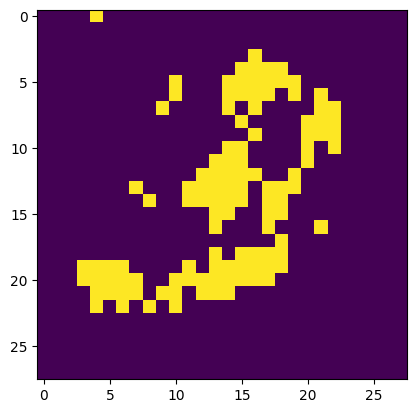

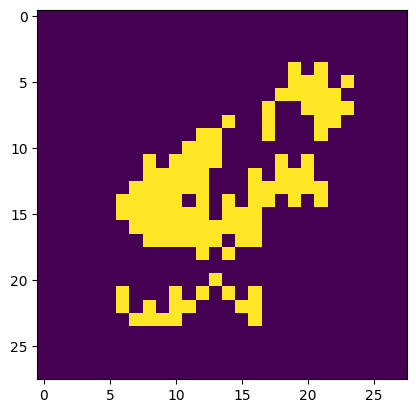

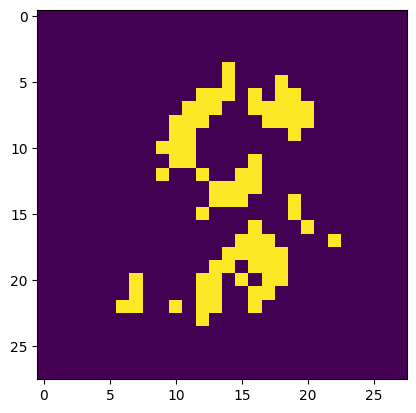

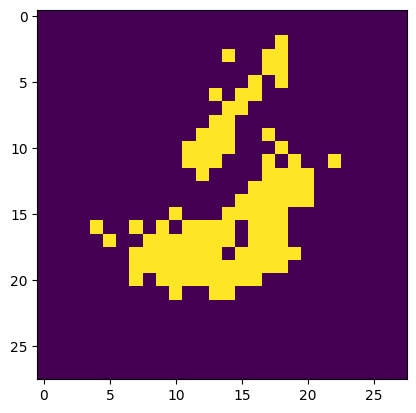

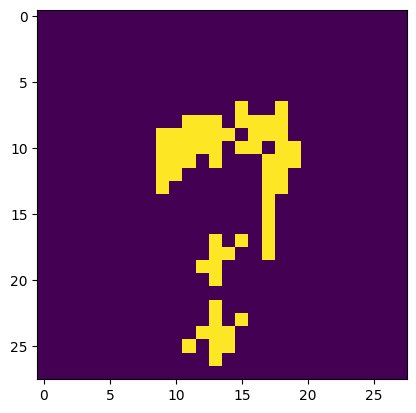

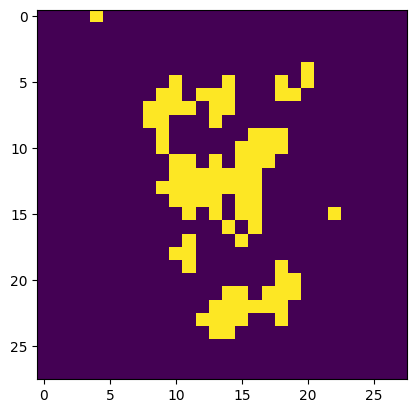

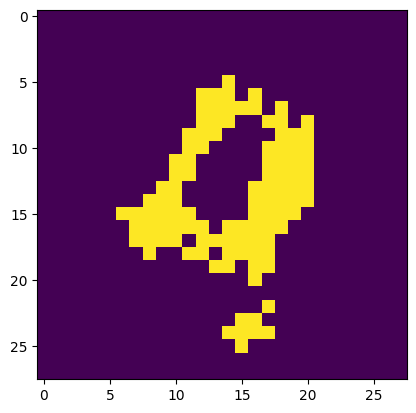

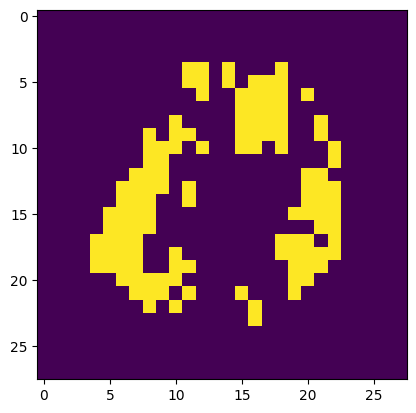

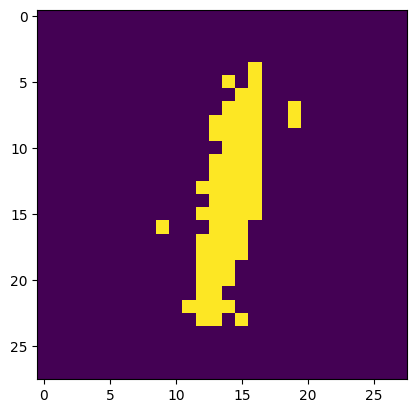

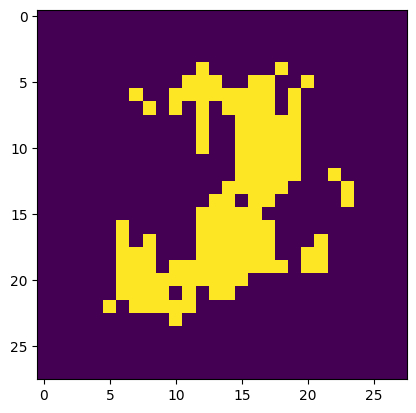

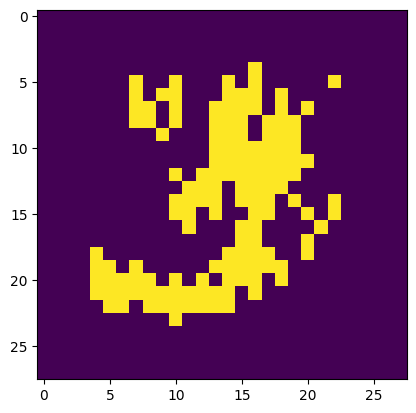

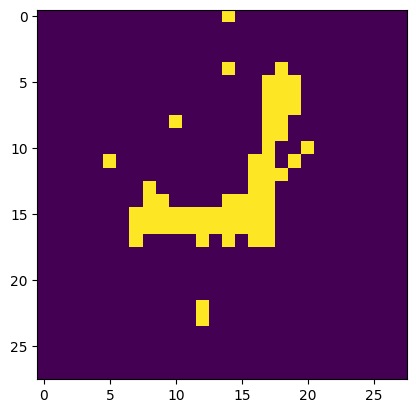

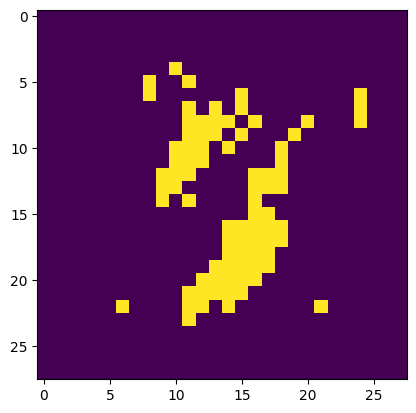

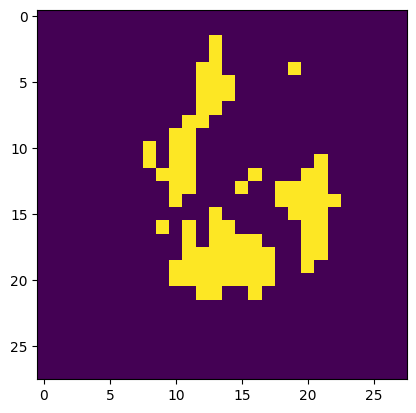

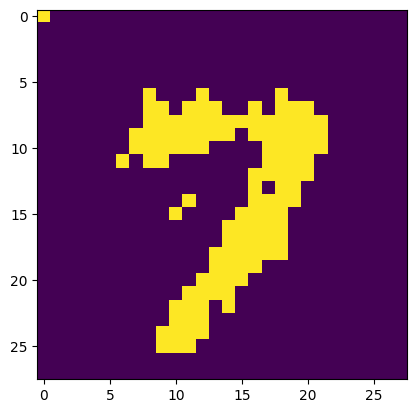

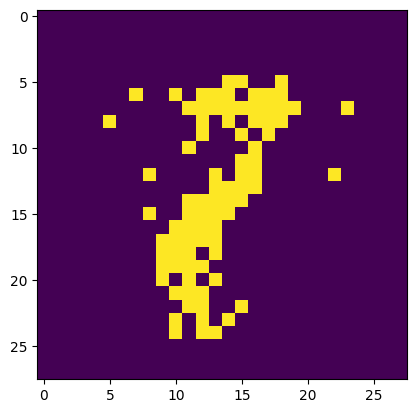

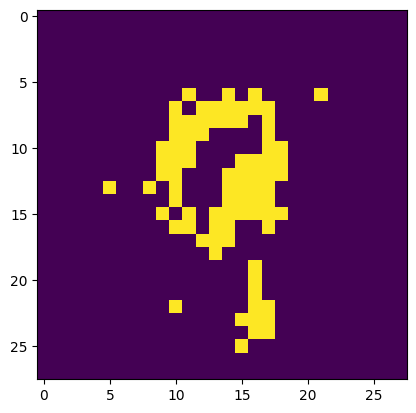

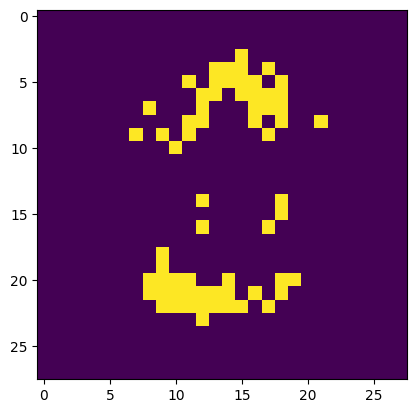

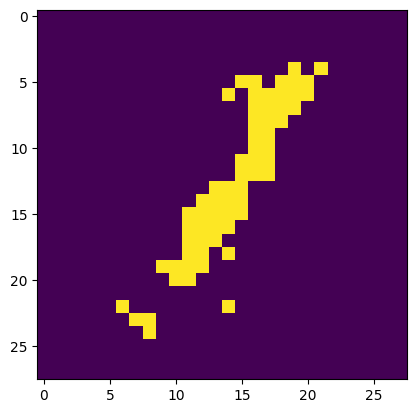

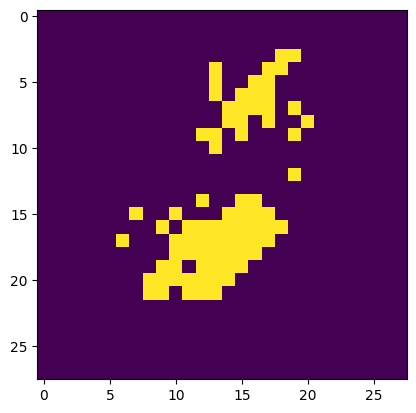

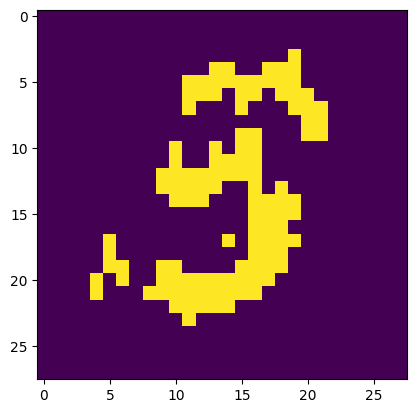

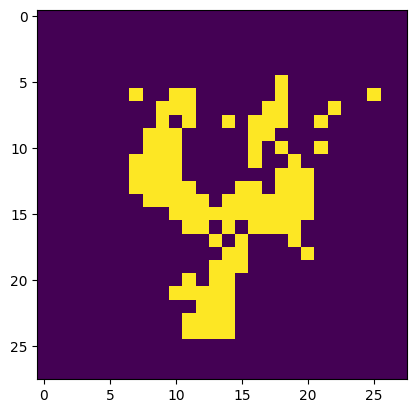

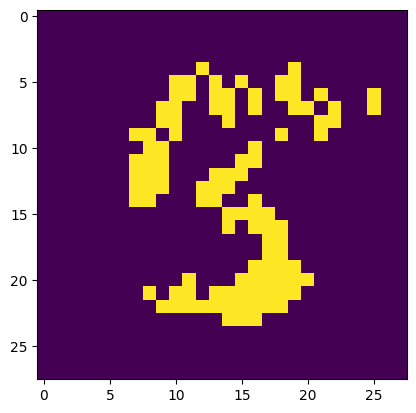

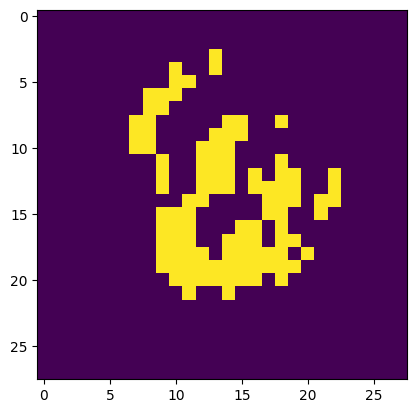

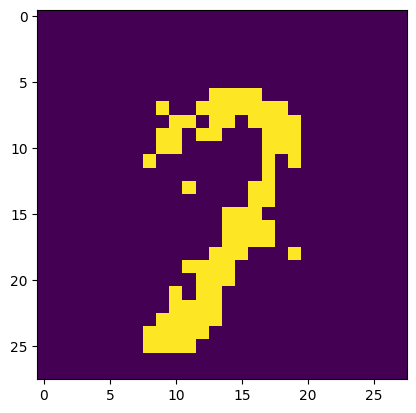

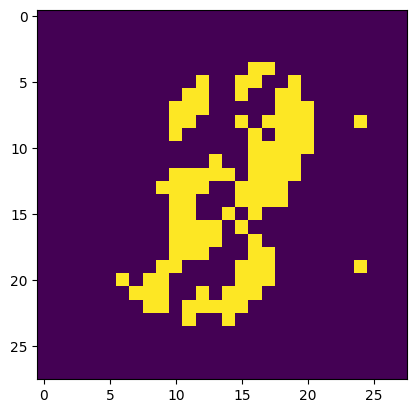

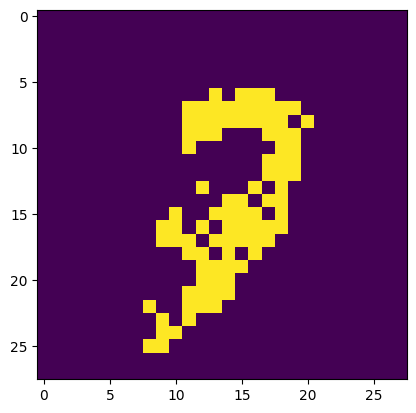

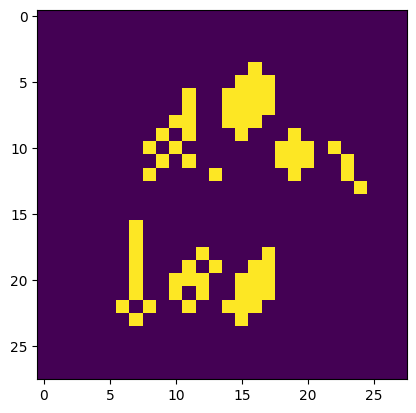

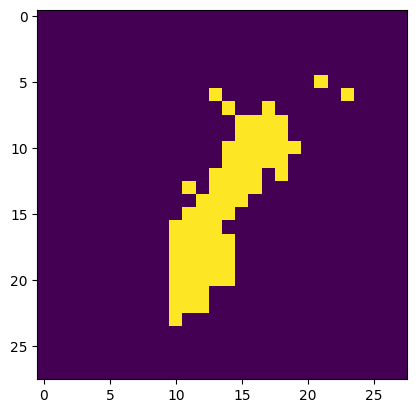

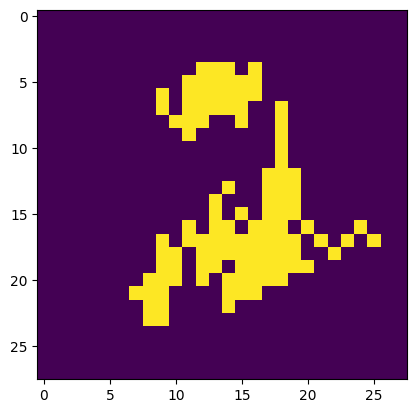

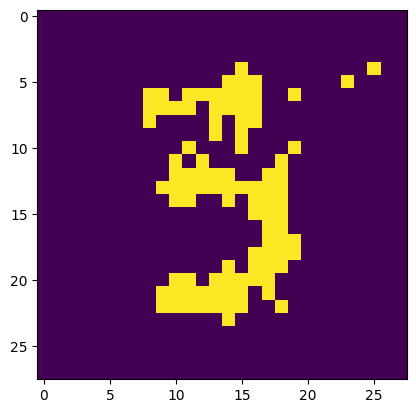

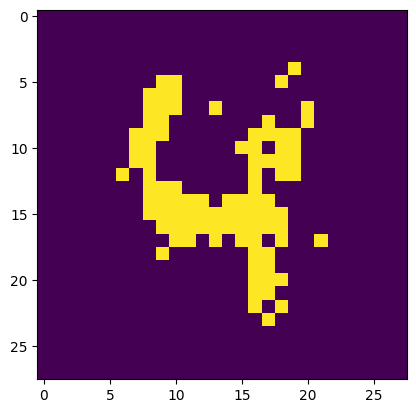

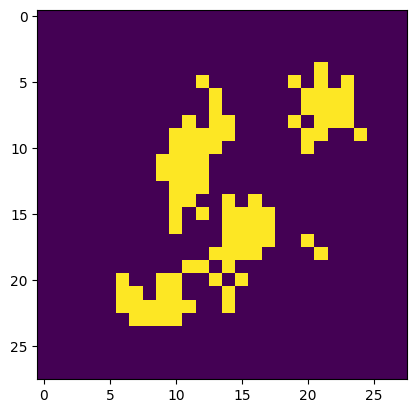

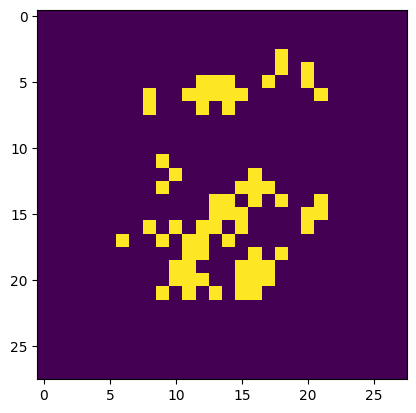

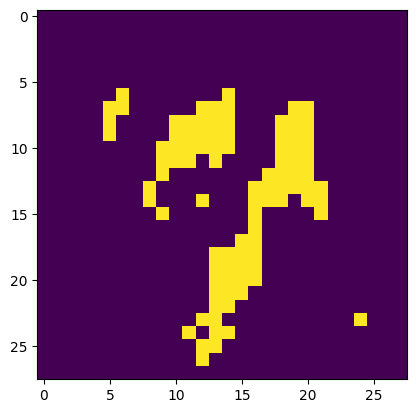

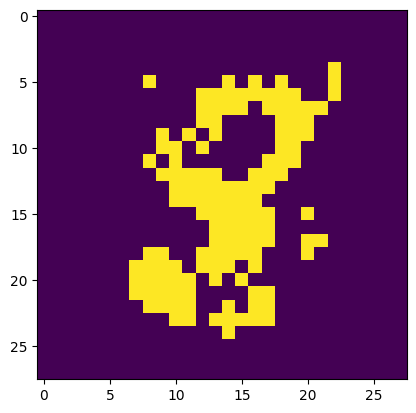

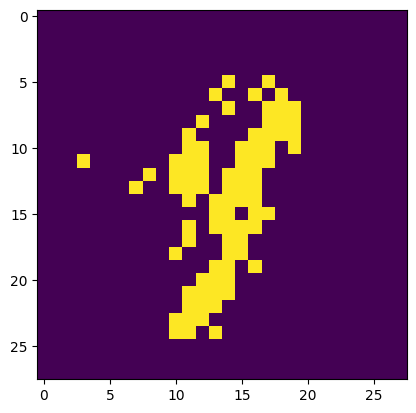

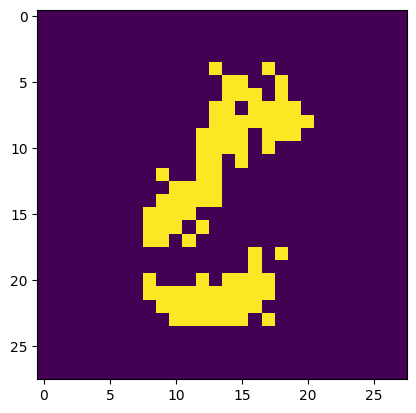

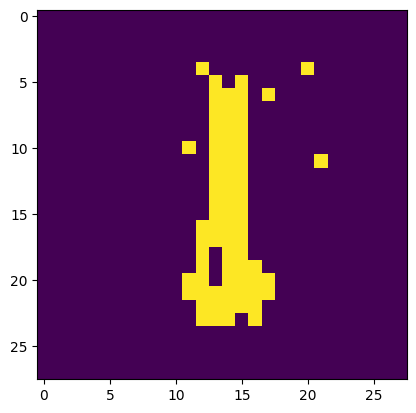

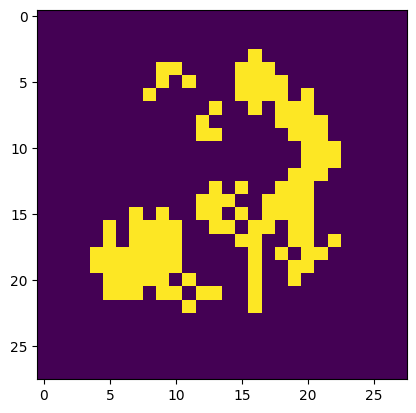

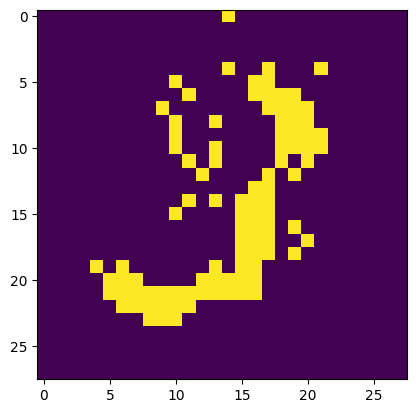

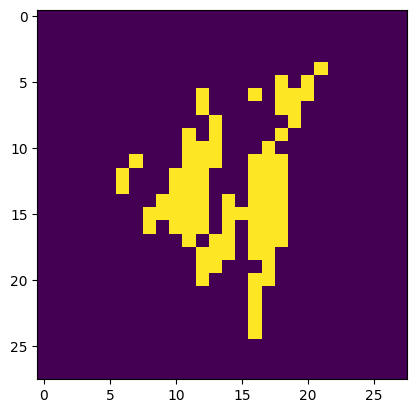

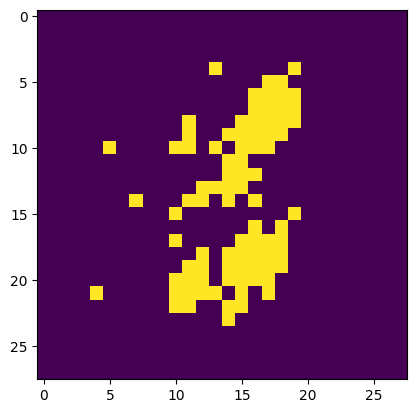

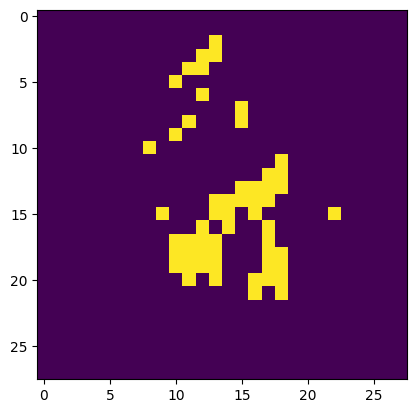

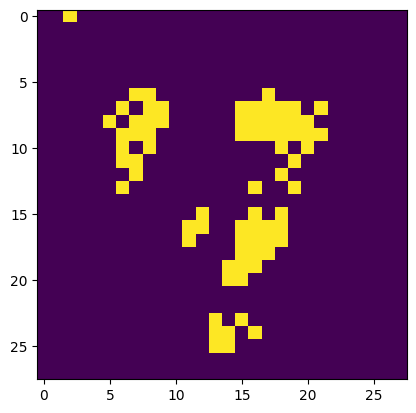

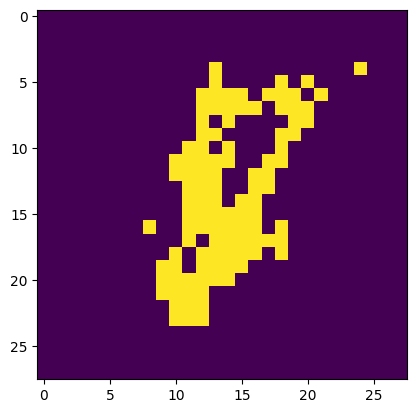

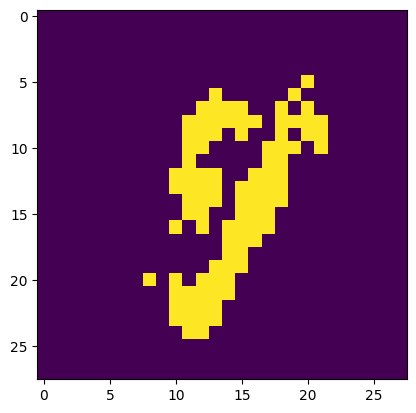

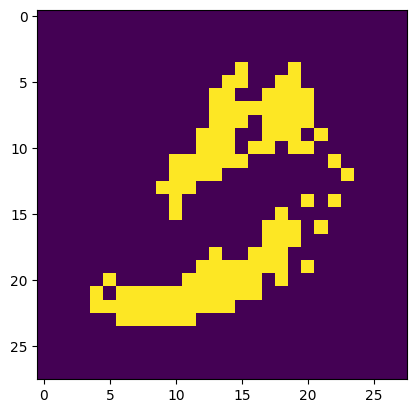

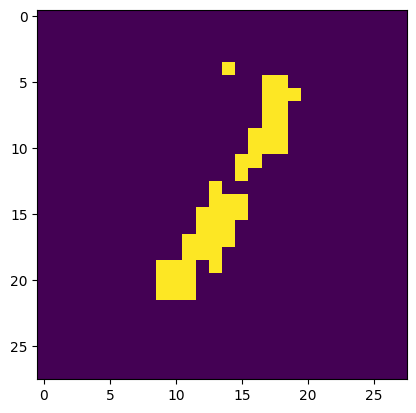

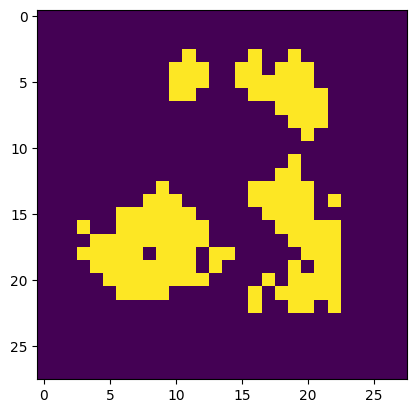

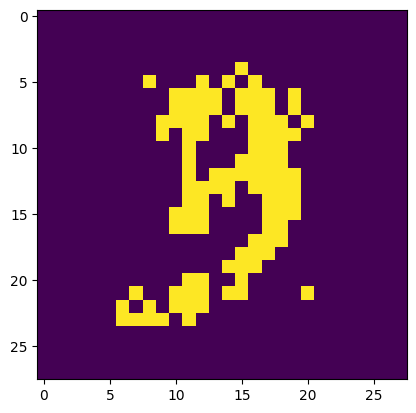

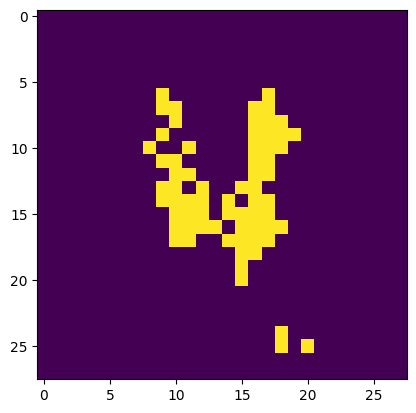

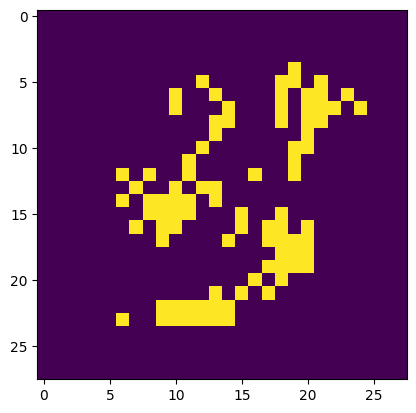

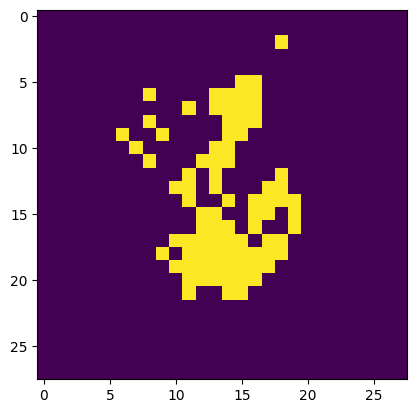

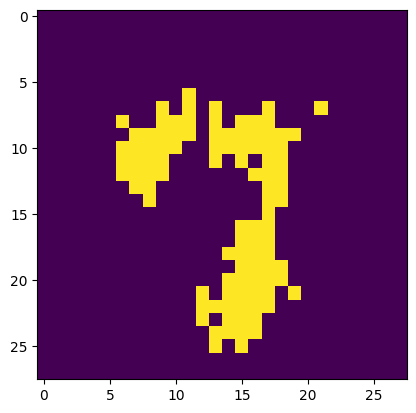

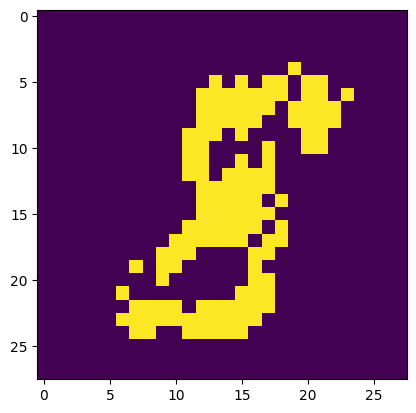

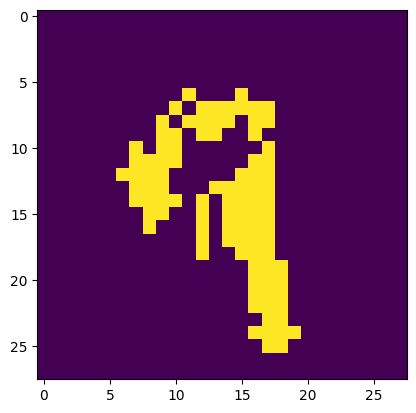

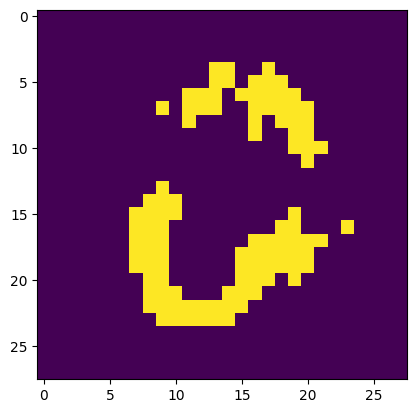

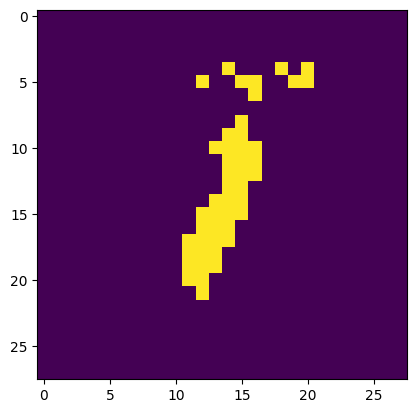

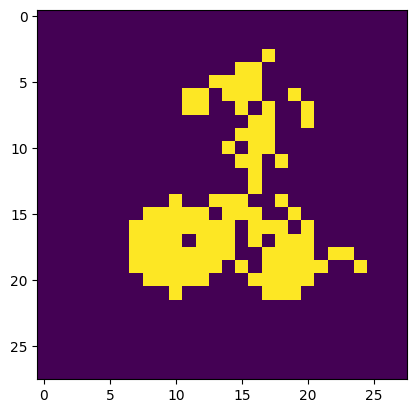

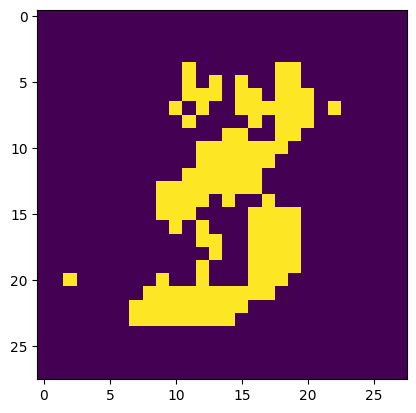

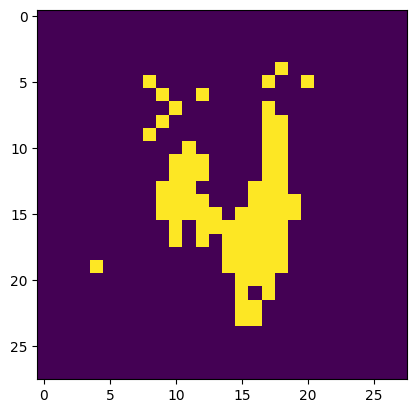

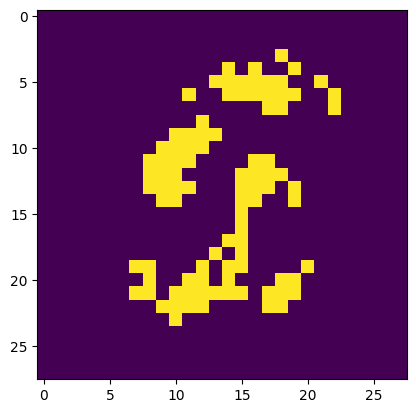

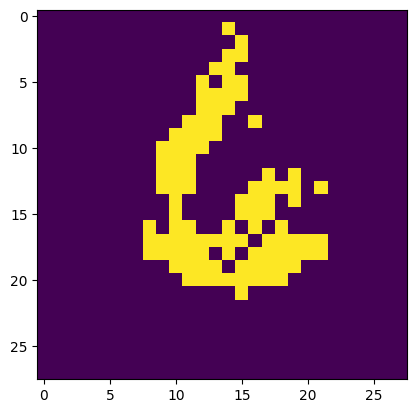

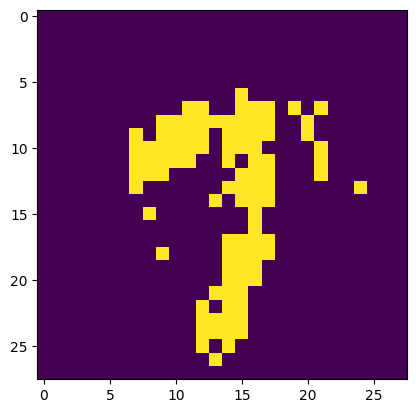

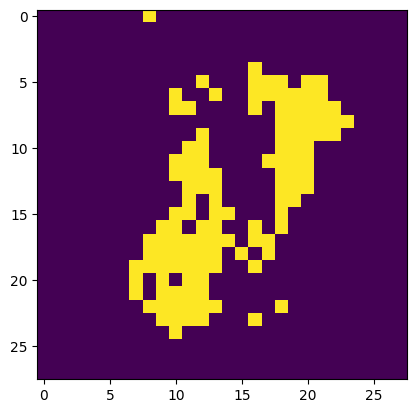

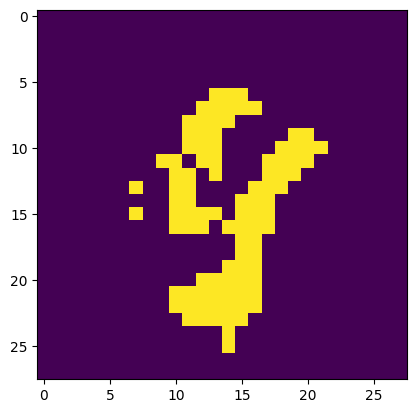

In [25]:
for i in range(res.shape[0]):
    img = res[i,0,:,:]
    plt.imshow(img)
    plt.show()